Raw data obtained from this <a href='https://ndownloader.figshare.com/files/12395030'>link</a> and contents extracted to the folder called data.

**Aim:** 

First import the python packages that will be used in this notebook.



In [23]:
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from scipy.stats import zscore

from tqdm import tqdm_notebook

Read the raster file containing the pre-flood data.

In [2]:
with rio.open('../data/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif') as src:
    # Convert / read the data into a numpy array:
    pre_dem_im = src.read(masked=True)
    # Create a spatial extent object using rio.plot.plotting
    pre_dem_spatial_extent = rio.plot.plotting_extent(src)
    # Get bounds of object
    pre_dem_bounds = src.bounds
    
    # Determine Coordinate Reference System (CRS):
    pre_dem_crs = src.crs
    
    # Determine the resolution of the LIDAR image:
    pre_dem_resolution = src.res 
    
    # Meta data
    pre_dem_meta = src.meta

Read the raster file containing the post-flood data.

In [3]:
with rio.open('../data/spatial/boulder-leehill-rd/post-flood/lidar/post_DTM.tif') as src:
    # Convert / read the data into a numpy array:
    post_dem_im = src.read(masked=True)
    # Create a spatial extent object using rio.plot.plotting
    post_dem_spatial_extent = rio.plot.plotting_extent(src)
    # Get bounds of object
    post_dem_bounds = src.bounds
    
    # Determine Coordinate Reference System (CRS):
    post_dem_crs = src.crs
    
    # Determine the resolution of the LIDAR image:
    post_dem_resolution = src.res 
    
    # Meta data
    post_dem_meta = src.meta

Make sure that both the pre and post flood LIDAR data is comparable so that a meaningful subtraction can be made.

In [4]:
assert pre_dem_spatial_extent == post_dem_spatial_extent
assert pre_dem_bounds == post_dem_bounds
assert pre_dem_crs == post_dem_crs
assert pre_dem_resolution == post_dem_resolution

Reshape the arrays into dimension (2000, 4000)

In [5]:
pre_dem_im = pre_dem_im.reshape(2000,4000)
post_dem_im = post_dem_im.reshape(2000,4000)

Determine the change in elevation by subtracting the post-flood LIDAR data with the pre-flood LIDAR data. 

In [6]:
change_dem_im = post_dem_im - pre_dem_im

Create a plot of the change in elevation data.

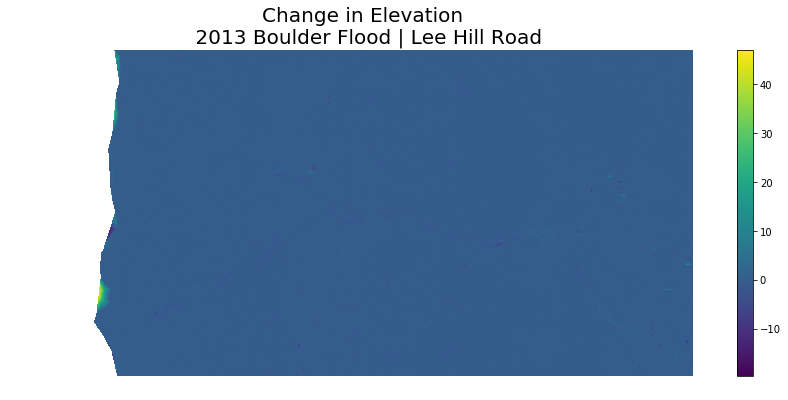

In [56]:
fig, ax = plt.subplots(figsize = (16,6))
lidar_plot = ax.imshow(change_dem_im, 
                       cmap='viridis')

ax.set_title("Change in Elevation \n 2013 Boulder Flood | Lee Hill Road", fontsize= 20)
fig.colorbar(lidar_plot)
# turn off the x and y axes for prettier plotting
ax.set_axis_off()
plt.show()

The distribution above is not that informative. It shows drastic elevation changes of approxiametely 40 metres, which appear dubiously around the border of the dataset. As such, this data will need to be filtered. In order to help determine upper and/or lower bounds to filter by, a distribution of the elevation will need to be chosen.

### Plotting the distribution of change in elevations 

In [9]:
change_in_elevations = change_dem_im.ravel().tolist()

Filter out the `None` data in the `change_in_elevations` list.

In [61]:
change_in_elevations = np.array([c for c in change_in_elevations if c is not None])

Summary statistics for these changes in elevations can be determined:

In [71]:
change_in_elevations.min(), change_in_elevations.max(), change_in_elevations.mean(), change_in_elevations.std()

(-19.6099853515625, 47.10009765625, 0.035030207322879724, 0.9237633233580155)

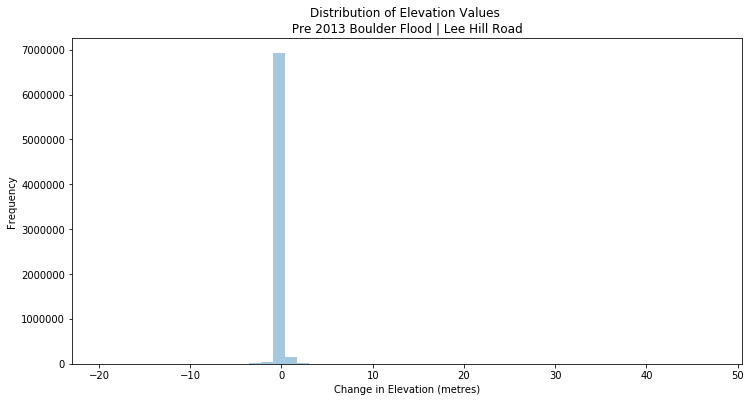

In [70]:
plt.figure(figsize=(12, 6));
sns.distplot(change_in_elevations, kde=False)

plt.xlabel('Change in Elevation (metres)')
plt.ylabel('Frequency')
plt.title('Distribution of Change in Elevation Values \n Pre 2013 Boulder Flood | Lee Hill Road ');

Create the variables `lower_limit` and `upper_limit` that represent the changes in elevation of interest.

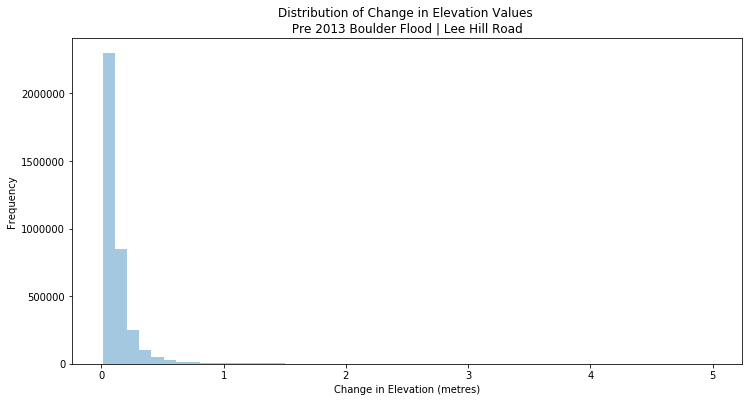

In [97]:
lower_limit = 0
upper_limit = 5


plt.figure(figsize=(12, 6));
sns.distplot(change_in_elevations[(change_in_elevations>lower_limit) & (change_in_elevations<upper_limit)], kde=False)

plt.xlabel('Change in Elevation (metres)')
plt.ylabel('Frequency')
plt.title('Distribution of Change in Elevation Values \n Pre 2013 Boulder Flood | Lee Hill Road ');

Define the function `plot_change_in_elevation(lower_limit, upper_limit)` which plots the elevation changes. If the change in elevation lies outside of the limits, it is plotted as 0 metres.

In [104]:
def plot_change_in_elevation(lower_limit, upper_limit):

    fig, ax = plt.subplots(figsize = (16,6))
    lidar_plot = ax.imshow((1*((change_dem_im>lower_limit) & (change_dem_im<upper_limit)))*change_dem_im, 
                       cmap='inferno')
    
    
    title = 'Change in Elevations Between {}m and {}m \n 2013 Boulder Flood | Lee Hill Road'.format(lower_limit, upper_limit)
    
    ax.set_title(title, fontsize= 20)
    fig.colorbar(lidar_plot)
    
    # turn off the x and y axes for prettier plotting
    ax.set_axis_off()
    plt.show()

Using the function above, it can be seen that:
    * No significant regions on the map have changes in elevation less that -15 metres.
    * There is a small region on the left boundary that has changes in elevation in the range -15 to -10 metres.
    * There are small patches of elevation changes between -10 and -5.
    * The majority of the flood's negative changes in elevation take place between -5 metres to 0 metres.

A plot of changes in elevation between -5 and 0 metres. This plot represents the terrain that has been weathered away during the flood.

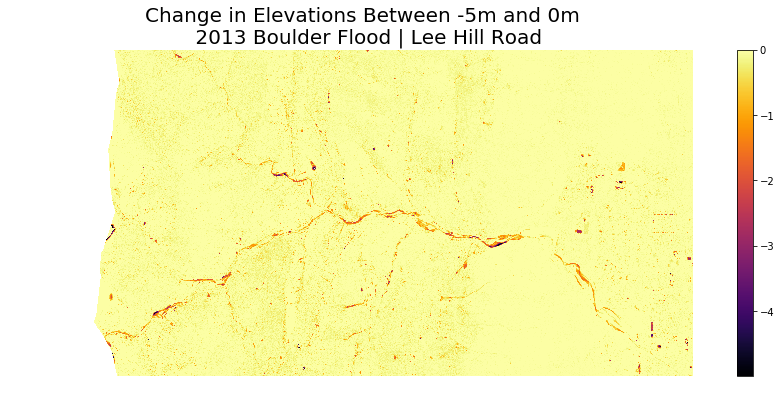

In [105]:
plot_change_in_elevation(-5, 0)

A plot of changes in elevation between -5 and 0 metres. This plot represents the terrain that has increased due to the flood.

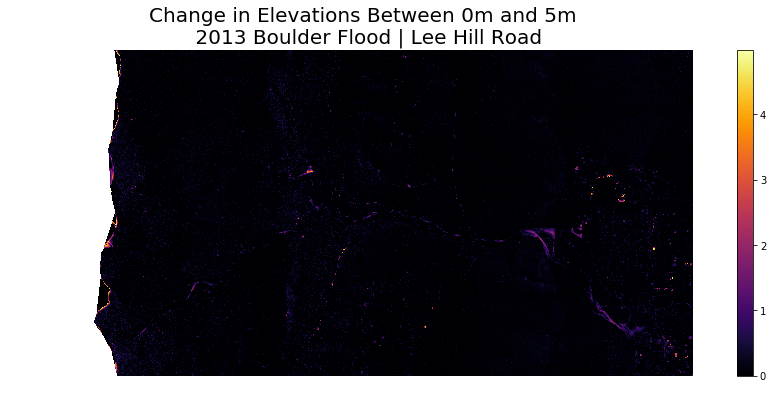

In [106]:
plot_change_in_elevation(0, 5)

A plot of changes in elevation between -5 and +5 metres

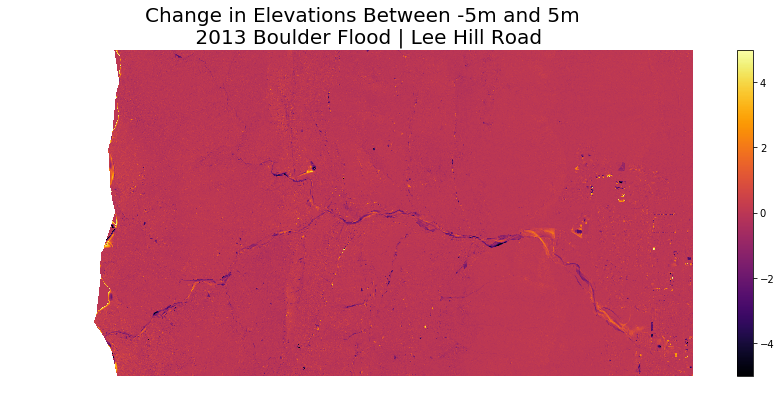

In [110]:
plot_change_in_elevation(-5, 5)